# Lights model with PBC2 dataset

In [1]:
# Library setup
%reset -f
%matplotlib inline
import os
os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Versions/4.0/Resources"
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from lifelines.utils import concordance_index as c_index_score
from lights.inference import prox_QNMCEM
from lights.base.utils import visualize_vect_learning, plot_history
import numpy as np
from sklearn.preprocessing import StandardScaler
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index as c_index_score
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline

def printmd(string):
    display(Markdown(string))
    
import rpy2.robjects as robjects
import warnings
%load_ext rpy2.ipython

In [2]:
%%R

library("JMbayes")

library("lcmm")

library("rstanarm")

library("glmnet")

library("ggplot2")

library("survminer")

R[write to console]: Le chargement a nécessité le package : nlme

R[write to console]: Le chargement a nécessité le package : survival

R[write to console]: Le chargement a nécessité le package : doParallel

R[write to console]: Le chargement a nécessité le package : foreach

R[write to console]: Le chargement a nécessité le package : iterators

R[write to console]: Le chargement a nécessité le package : parallel

R[write to console]: Le chargement a nécessité le package : rstan

R[write to console]: Le chargement a nécessité le package : StanHeaders

R[write to console]: Le chargement a nécessité le package : ggplot2

R[write to console]: Need help getting started? Try the R Graphics Cookbok:
https://r-graphics.org

R[write to console]: rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

R[write to console]: For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend

2 PBC dataset
=============

This dataset is a follow-up to the original dataset from the Mayo Clinic
trial in primary biliary cirrhosis (PBC) of the liver conducted between
1974 and 1984. A total of 424 PBC patients, referred to Mayo Clinic
during that ten-year interval, met eligibility criteria for the
randomized placebo controlled trial of the drug D-penicillamine. The
first 312 cases in the data set participated in the randomized trial and
contain largely complete data. The additional 112 cases did not
participate in the clinical trial, but consented to have basic
measurements recorded and to be followed for survival. Six of those
cases were lost to follow-up shortly after diagnosis, so the data here
are on an additional 106 cases as well as the 312 randomized
participants. The dataset contains only baseline measurements of the
laboratory paramters and contains multiple laboratory results, but only
on the first 312 patients. The data are in open-access in *JMbayes*
package.

2.1 Longitudinal outcomes
-------------------------

In [3]:
%%R
# load data

data(pbc2, package = "JMbayes")

colnames_pbc2 <- names(pbc2)

To illutrate the competing models, three longitudinal outcomes are
considered: serum bilirubin (in mg/dl), albumin (in gm/dl), and SGOT (in
U/ml). Figure below presents the log of repeated measurements for each
outcome.

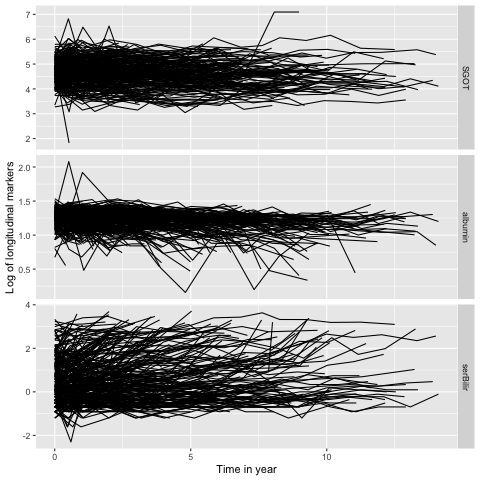

In [4]:
%%R

pbc2_long <- rbind(pbc2[, c("id", "years", "status", "drug", "age", "sex", "year")], 

    pbc2[, c("id", "years", "status", "drug", "age", "sex", "year")], pbc2[, c("id", 

        "years", "status", "drug", "age", "sex", "year")])



pbc2_long$Y <- c(pbc2$serBilir, pbc2$albumin, pbc2$SGOT)



pbc2_long$logY <- log(pbc2_long$Y)



pbc2_long$markers <- c(rep("serBilir", length(pbc2$serBilir)), rep("albumin", length(pbc2$albumin)), 

    rep("SGOT", length(pbc2$SGOT)))



ggplot(pbc2_long, aes(x = year, y = logY, group = id)) + geom_line() + facet_grid(markers ~ 

    ., scales = "free_y") + theme(legend.position = "none") + labs(x = "Time in year") + 

    labs(y = "Log of longitudinal markers")

2.2 Surival data
----------------

In [5]:
%%R
# load data

data(pbc2.id, package = "JMbayes")

The event of interest is the death and time-to-event is the minimum
between the times of the event of interest and censoring times. 140
events are observed. The figure below shows the Kaplan-Meier curve
estimated from the data.

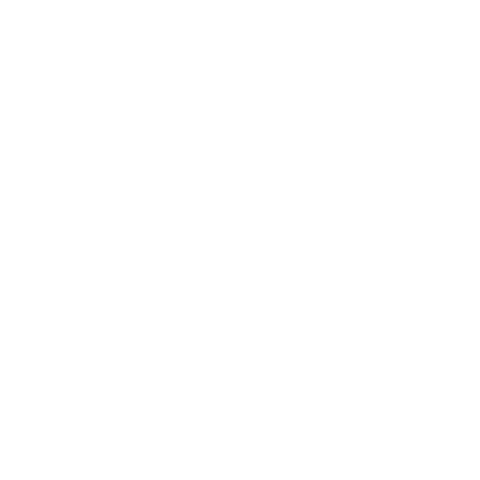

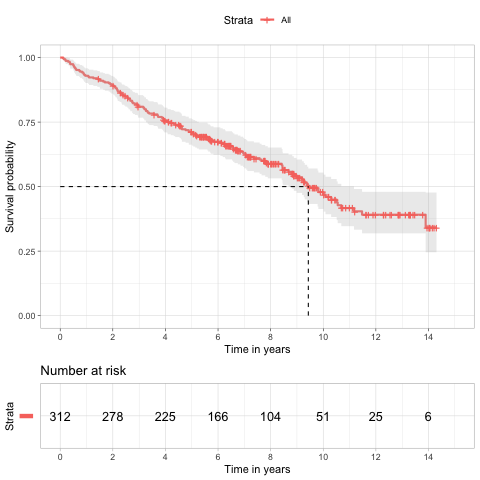

In [6]:
%%R

fit <- survfit(Surv(years, status2) ~ 1, data = pbc2.id)

ggsurvplot(

   fit,                     # survfit object with calculated statistics.

   data = pbc2.id,          # data used to fit survival curves.

   risk.table = TRUE,       # show risk table.

   conf.int = TRUE,         # show confidence intervals for 

                            # point estimates of survival curves.

                            # survival estimates.

   xlab = "Time in years",  # customize X axis label.

   break.time.by = 2,       # break X axis in time intervals by 2.

   ggtheme = theme_light(), # customize plot and risk table with a theme.

   risk.table.y.text.col = T, # colour risk table text annotations.

   risk.table.y.text = FALSE, # show bars instead of names in text annotations

   surv.median.line = "hv"  # add the median survival pointer.

)

2.3 Selection of training and test datasets
-------------------------------------------

To illustrate the competing models, 4/5 of the subjects (n=250) were
randomly selected to form the training data for fitting joint models,
and the remaining 1/5 (n=62) were used to form the test data for
evaluation of prediction.

In [7]:
%%R

# Select training and test samples

pbc2$id <- as.numeric(pbc2$id)

set.seed(2020)

lenght_id <- length(unique(pbc2$id))

id_test <- sample(unique(pbc2$id), round(lenght_id/5))

# training dataset

data_training <- pbc2[which(!(pbc2$id %in% id_test)), ]

data_training.id <- unique(data_training[, c("id", "years", "status2", "drug", "sex")])

# test dataset

# TODO: For the data test, we considered the measurements up to $t=5$.
# We chose $t=5$ because with $t=4$, there is no observed event in
# testing dataset and until now lcmm package needs to observed events in order to update the model.

tmax <- 4

data_test <- pbc2[which(pbc2$id %in% id_test), ]

#data_test$real_event <- data_test$status2

#data_test$real_years <- data_test$years

#data_test$status2[which(data_test$years > tmax)] <- 0

#data_test$years[which(data_test$years > tmax)] <- tmax

#data_test.id <- unique(data_test[, c("id", "years", "status2", "drug", "sex", "real_years", 

#    "real_event")])

data_test.id <- unique(data_test[, c("id", "years", "status2", "drug", "sex")])

3 Competing models
==================

3.1 Penalized Cox model with time-independent features.
-------------------------------------------------------

The first model we consider as a baseline is the well known Cox PH model
with time-independent features. In this model introduced in
{Cox1972JRSS}, a parameter vector $\beta$ is estimated by minimizing the
partial log-likelihood given by 

$$
\ell_n^{\text{cox}}(\beta) = n^{-1} \sum_{i=1}^n \delta_i \big(
x_i^\top \beta - \log \sum_{i' : t_{i'} \geq t_i}
\text{exp}(x_{i'}^\top \beta) \big).
$$

We use respectively the **R** packages *survival* and *glmnet*
{simon2011regularization} for the partial log-likelihood and the
minimization of the following quantity

$$
- \ell_n^{\text{cox}}(\beta) + \xi \big( (1-\eta)||\beta||_1
+ \frac{\eta}{2} ||\beta||_2^2 \big),
$$

where $\xi$ is chosen by the a 10-fold cross-validation procedure, for a given $\eta \in [0, 1]$. Ties are handled
via the Breslow approximation of the partial likelihood . We also choose to include basic time-independent features extracted from longitudinal processes, namely for each time-dependant feature:

-   subject-specific random effects;
-   values of longitudinal processes at baseline and at time $t_{max}$;
-   slope of longitudinal processes at time $t_{max}$;
-   area under of longitudinal processes from baseline up to $t_{max}$.

To get longitudinal features, the following **R** function has been
developed.

In [8]:
%%R

# function to get features

lfeatures <- function(model, tmax, formFixed, formRandom, formGroup, data, derivForm = NULL, 

    aeraForm = NULL, timeVar, col_name = "") {

    # subject-specific random effects

    X.id <- as.matrix(model$predRE, ncol = 1)

    RE <- X.id[, -1]

    colnames(X.id) <- paste("RE.", colnames(X.id), sep = "")

    # value

    data.id <- data[!duplicated(as.integer(data[all.vars(formGroup)][, 1])), ]

    if (length(tmax) == 1) 

        tmax <- rep(tmax, nrow(X.id))

    data.id[[timeVar]] <- tmax

    mfX.id <- model.frame(formFixed, data = data.id)

    mfU.id <- model.frame(formRandom, data = data.id)

    Xtime <- model.matrix(formFixed, mfX.id)

    Utime <- model.matrix(formRandom, mfU.id)

    value <- Xtime %*% model$best[1:ncol(Xtime)] + diag(Utime %*% t(RE))

    # derivation

    mfX.deriv.id <- model.frame(derivForm$fixed, data = data.id)

    mfU.deriv.id <- model.frame(derivForm$random, data = data.id)

    Xtime.deriv <- model.matrix(derivForm$fixed, mfX.deriv.id)

    Utime.deriv <- model.matrix(derivForm$random, mfU.deriv.id)

    if (!is.null(derivForm$indFixed)) {

        slope <- Xtime.deriv %*% model$best[derivForm$indFixed] + diag(Utime.deriv %*% 

            t(RE[, derivForm$indRandom]))

    } else {

        slope <- Xtime.deriv %*% model$best[1:ncol(Xtime)] + diag(Utime.deriv %*% 

            t(RE))

    }

    # aera

    mfX.aera.id <- model.frame(aeraForm$fixed, data = data.id)

    mfU.aera.id <- model.frame(aeraForm$random, data = data.id)

    Xtime.aera <- model.matrix(aeraForm$fixed, mfX.aera.id)

    Utime.aera <- model.matrix(aeraForm$random, mfU.aera.id)

    if (!is.null(aeraForm$indFixed)) {

        aera <- Xtime.aera %*% model$best[aeraForm$indFixed] + diag(Utime.aera %*% 

            t(RE[, aeraForm$indRandom]))

    } else {

        aera <- Xtime.aera %*% model$best[1:ncol(Xtime)] + diag(Utime.aera %*% t(RE))

    }

    # output

    X.id <- data.frame(X.id)

    out <- cbind(X.id, value, slope, aera)

    colnames(out) <- paste(col_name, ".", colnames(out), sep = "")

    colnames(out)[1] <- "id"

    out

}

Then, we create the matrix including the subject-specifics longitudinal features at $t_{max}$:

In [9]:
%%R

## estimated LMM

library(lcmm)

data_training$log.serBilir <- log(data_training$serBilir)

data_training$log.SGOT <- log(data_training$SGOT)

data_training$log.albumin <- log(data_training$albumin)

# Keep measurements up to t

hlme_data <- data_training[which(data_training$year <= 4), ]

model.serBilir <- hlme(fixed = log.serBilir ~ year + I(year^2), random = ~year, subject = "id", 

    ng = 1, data = hlme_data)

model.SGOT <- hlme(fixed = log.SGOT ~ year + I(year^2), random = ~year, subject = "id", 

    ng = 1, data = hlme_data)

model.albumin <- hlme(fixed = log.albumin ~ year + I(year^2), random = ~year, subject = "id", 

    ng = 1, data = hlme_data)

# get longitudinal features arguments

derivForm = list(fixed = ~I(2 * year), random = ~1, indFixed = c(2, 3), indRandom = c(2))

aeraForm = list(fixed = ~-1 + year + I(year^2/2) + I(year^3/3), random = ~-1 + year + 

    I(year^2/2), indFixed = NULL, indRandom = NULL)

feature.serBilir <- lfeatures(model = model.serBilir, tmax = 4, formFixed = log.serBilir ~ 

    year + I(year^2), formRandom = ~year, derivForm = derivForm, aeraForm = aeraForm, 

    formGroup = ~id, timeVar = "year", col_name = "serBili", data = hlme_data)

feature.SGOT <- lfeatures(model = model.SGOT, tmax = 4, formFixed = log.serBilir ~ 

    year + I(year^2), formRandom = ~year, derivForm = derivForm, aeraForm = aeraForm, 

    formGroup = ~id, timeVar = "year", col_name = "SGOT", data = hlme_data)

feature.albumin <- lfeatures(model = model.albumin, tmax = 4, formFixed = log.serBilir ~ 

    year + I(year^2), formRandom = ~year, derivForm = derivForm, aeraForm = aeraForm, 

    formGroup = ~id, timeVar = "year", col_name = "albumin", data = hlme_data)

# all longitudinal features

X.id <- cbind(feature.serBilir, feature.SGOT[, -1], feature.albumin[, -1])

Be patient, hlme is running ... 
The program took 0.07 seconds 
Be patient, hlme is running ... 
The program took 0.11 seconds 
Be patient, hlme is running ... 
The program took 0.11 seconds 


Finally, we fit the surival model using *glmnet* package.

In [10]:
%%R
# estimation of penealized cox model

library(glmnet)

data.surv.X <- as.matrix(X.id[, -1])

data.surv.T <- data_training.id$years

data.surv.E <- data_training.id$status2

# lasso with alpha=1, EN : find alpha between 0 and 1 minimizing 'cvm' output

cv.coxnet.fit <- cv.glmnet(data.surv.X, Surv(data.surv.T, data.surv.E), family = "cox", 

    alpha = 1, nfolds = 10)

# use the best penality parameter

best.lambda <- cv.coxnet.fit$lambda.min

coxnet.fit <- glmnet(data.surv.X, Surv(data.surv.T, data.surv.E), family = "cox", 

    lambda = best.lambda, alpha = 1)

# 

Coefficients <- coef(coxnet.fit, s = cv.coxnet.fit$lambda.min)

Active.Index <- which(Coefficients != 0)

For the prediction step, we need to compute individual longitudinal features, and we then predict survival probability.

In [11]:
%%R

# prediction using the test dataset

data_test$log.serBilir <- log(data_test$serBilir)

data_test$log.SGOT <- log(data_test$SGOT)

data_test$log.albumin <- log(data_test$albumin)

# estimated model (test)

model.serBilir.test <- hlme(fixed = log.serBilir ~ year + I(year^2), random = ~year, 

    subject = "id", ng = 1, B = model.serBilir$best, maxiter = 0, data = data_test)

model.SGOT.test <- hlme(fixed = log.SGOT ~ year + I(year^2), random = ~year, subject = "id", 

    ng = 1, B = model.SGOT$best, maxiter = 0, data = data_test)

model.albumin.test <- hlme(fixed = log.albumin ~ year + I(year^2), random = ~year, 

    subject = "id", ng = 1, B = model.albumin$best, maxiter = 0, data = data_test)

# arguments

derivForm = list(fixed = ~I(2 * year), random = ~1, indFixed = c(2, 3), indRandom = c(2))

aeraForm = list(fixed = ~-1 + year + I(year^2/2) + I(year^3/3), random = ~-1 + year + 

    I(year^2/2), indFixed = NULL, indRandom = NULL)

feature.serBilir <- lfeatures(model = model.serBilir.test, tmax = 4, formFixed = log.serBilir ~ 

    year + I(year^2), formRandom = ~year, derivForm = derivForm, aeraForm = aeraForm, 

    formGroup = ~id, timeVar = "year", col_name = "serBili", data = data_test)

feature.SGOT <- lfeatures(model = model.SGOT.test, tmax = 4, formFixed = log.serBilir ~ 

    year + I(year^2), formRandom = ~year, derivForm = derivForm, aeraForm = aeraForm, 

    formGroup = ~id, timeVar = "year", col_name = "SGOT", data = data_test)

feature.albumin <- lfeatures(model = model.albumin.test, tmax = 4, formFixed = log.serBilir ~ 

    year + I(year^2), formRandom = ~year, derivForm = derivForm, aeraForm = aeraForm, 

    formGroup = ~id, timeVar = "year", col_name = "albumin", data = data_test)

# all longitudinal features

data.surv.Xtest <- as.matrix(cbind(feature.serBilir[, -1], feature.SGOT[, -1], feature.albumin[, 

    -1]))

data_test.id$years

# prediction

coxnetFit.coxph <- coxph(Surv(data_test.id$years, data_test.id$status2) ~ ., data = as.data.frame(
    data.surv.Xtest[,Active.Index]), init = coef(coxnet.fit)[Active.Index], iter = 0, x = TRUE)

# or predictive marker

p_coxph_en <- predict(coxnet.fit, newx = as.matrix(data.surv.Xtest), type = "response")

# p_coxph_en <- exp(as.matrix(data.surv.Xtest[,

# Active.Index])%*%coef(coxnet.fit)[Active.Index])



# save 
save(model.albumin, model.serBilir, model.SGOT, data.surv.X, data.surv.T, data.surv.E, data.surv.Xtest,
     model.albumin.test, model.serBilir.test,model.SGOT.test, cv.coxnet.fit,coxnet.fit,coxnetFit.coxph,
     p_coxph_en, file = 'coxph_en.Rdata')

Be patient, hlme is running ... 
The program took 0.01 seconds 
Be patient, hlme is running ... 
The program took 0.01 seconds 
Be patient, hlme is running ... 
The program took 0.02 seconds 


In [12]:
%%R

# load outputs

load(file = "coxph_en.Rdata")

# longitdinal features

head(data.surv.X)

   serBili.RE.intercept serBili.RE.year serBili.value serBili.slope
6           -0.55850863     0.067706048    1.05073467     0.3940594
15          -0.27764993     0.002139636    1.06932771     0.3284930
20          -0.01373991     0.059348580    1.56207351     0.3857019
28           0.28097558     0.228750316    2.53439594     0.5551037
32          -0.71159493    -0.170622159   -0.05566447     0.1557312
46          -1.30931937     0.038339260    0.18245677     0.3646926
   serBili.aera SGOT.RE.intercept SGOT.RE.year SGOT.value  SGOT.slope SGOT.aera
6     1.7136077         0.1551333   0.02106631   4.926380 -0.00746955  19.63823
15    2.3125112        -0.3219811  -0.02519264   4.264230 -0.05372849  17.35970
20    3.8258228         0.1398050   0.07728101   5.135910  0.04874515  20.02664
28    6.3598987         0.1084628   0.05313330   5.007977  0.02459744  19.70808
32   -0.8053632        -0.3793076  -0.05314773   4.095083 -0.08168359  16.90676
46   -1.5245696        -0.1720090   0.092680

In [13]:
%%R

# coefficients using EN pen

coef(coxnet.fit)

15 x 1 sparse Matrix of class "dgCMatrix"
                              s0
serBili.RE.intercept  .         
serBili.RE.year       .         
serBili.value         0.82239140
serBili.slope         .         
serBili.aera          0.05888626
SGOT.RE.intercept    -0.71027822
SGOT.RE.year          .         
SGOT.value            .         
SGOT.slope            .         
SGOT.aera             .         
albumin.RE.intercept -6.02108768
albumin.RE.year       .         
albumin.value        -1.32371268
albumin.slope         .         
albumin.aera         -0.18079426


In [14]:
%%R
# predictive marker

head(p_coxph_en)

             s0
2   49.60533839
41   0.04944452
83   0.04396651
152  1.25743859
154 19.45743119
179  0.01758283


3.2 Multivariate joint latent class model.
------------------------------------------

Among joint modeling approaches, a multivariate version of JLCMs is considered. Several longitudinal markers and time-to-event data are jointly fitted assuming that that the behavior of each response is determined by belonging to a latent homogeneous subpopulation. Contrary to the lights model, there are no shared associations between the
longitudinal models and the survival model. Given the group membership, each submodel are assumed to be independent. Therefore, the predictive marker is 

$$
\hat{\mathcal{R}}_{ik}^{(lcmm)} = \frac{\pi_{k}(\hat \theta)
\hat f(t^{max}_i \| G_i=k ; \hat \theta)\hat f(y_i | G_i=k ;
\hat \theta)}{\sum_{k=0}^{K-1} \pi_{k}(\hat \theta) \hat
f(t^{max}_i \| G_i=k ; \hat \theta)\hat f(y_i \| G_i=k ; \hat
\theta)}, 
$$

where each quantities are already defined
assuming only latent class approach. The multivariate JLCM is
implemented by {proust2017lcmm} in the **R** package *lcmm*.

In [15]:
%%R

library(lcmm)



# data management

pbc2_lcmm <- data_training

pbc2_lcmm$id <- as.numeric(data_training$id)

pbc2_lcmm$log.serBilir <- log(data_training$serBilir)

pbc2_lcmm$log.SGOT <- log(data_training$SGOT)

pbc2_lcmm$log.albumin <- log(data_training$albumin)

pbc2_lcmm_test <- data_test

# need one subject with an event : creation of a fake subject

tmp <- data_test[which(data_test$id == data_test$id[1]), ]

tmp$status2 <- 1

tmp$id <- 9999

pbc2_lcmm_test <- rbind(pbc2_lcmm_test, tmp)

pbc2_lcmm_test$id <- as.numeric(pbc2_lcmm_test$id)

pbc2_lcmm_test$log.serBilir <- log(pbc2_lcmm_test$serBilir)

pbc2_lcmm_test$log.SGOT <- log(pbc2_lcmm_test$SGOT)

pbc2_lcmm_test$log.albumin <- log(pbc2_lcmm_test$albumin)



# joint model including 2 classes specify longitudinal model for 2 classes,

# without estimation B

mult2 <- multlcmm(log.serBilir + log.SGOT + log.albumin ~ year + I(year^2), random = ~year, 

    subject = "id", nwg = TRUE, ng = 2, mixture = ~year + I(year^2), data = pbc2_lcmm, 

    maxiter = 0)

### (>The program took 0.09 seconds) estimation of the associated joint model

lcmm_estim <- mpjlcmm(longitudinal = list(mult2), subject = "id", ng = 2, data = pbc2_lcmm, 

    classmb = ~drug + sex + age, survival = Surv(years, status2) ~ mixture(drug) + 

        mixture(sex), hazard = "Weibull", hazardtype = "PH")

### (>The program took 423.45 seconds) prediction for new subject

lcmm_pred <- mpjlcmm(longitudinal = list(mult2), B = lcmm_estim$best, maxiter = 0, 

    subject = "id", ng = 2, data = pbc2_lcmm_test, classmb = ~drug + sex + age, survival = Surv(years, 

        status2) ~ mixture(drug) + mixture(sex), hazard = "Weibull", hazardtype = "PH")

### (>The program took 0.1 seconds)

save(pbc2_lcmm, pbc2_lcmm_test, mult2, lcmm_estim, lcmm_pred, file= 'lcmm_pbc2_3mv.Rdata')

Be patient, multlcmm is running ... 
The program took 0.11 seconds 
The program took 468.73 seconds 
The program took 0.05 seconds 


Note that *maxiter=0* allows to obtain individual prediction based on
estimated model from the training dataset. An update of parameters could
be obtained using *maxiter\>0*. The output including class membership
and posterior probabilities of class memebership is:

In [16]:
%%R

# load lcmm output

load("lcmm_pbc2_3mv.Rdata")

head(lcmm_pred$pprob)

  id class      probYT1      probYT2
1  1     2 7.608892e-05 9.999239e-01
2  7     1 9.912172e-01 8.782814e-03
3 13     1 1.000000e+00 1.203214e-11
4 22     2 8.414894e-02 9.158511e-01
5 23     2 2.243104e-06 9.999978e-01
6 25     1 9.999442e-01 5.582799e-05


3.3 Multivariate shared random effect model
-------------------------------------------

In shared random effect model approach, we considered multivariate joint models for multiple longitudinal outcomes and an event time. Several **R** package exist: *JMbayes*, *rstanarm* and *joineRML* for instance. For reasons of computational cost, flexibility and visibility, we use the *JMbayes* package {2017\_JMbayes}. It allows the estimation of the *lights* model without penalty and assuming that the population is homogeneous (i.e. without assuming latent classes). For a new subject $i$, the predictive marker associated with this model is the dynamic prediction of the conditional survival at time $t+s$ given the suject has survived up to time $t$ and his longitudinal measurements until time $t$. The probability is defined by: 

$$
\Pr\left(T_i^\star>t+s\vert T_i^\star>t,
\mathcal{Y}_{i}(t),\mathcal{D}_n; {\theta}\right)
$$

where 
$\mathcal{Y}_{i}(t)=\{\mathcal{Y}_{i}^1(t),\ldots,\mathcal{Y}_{i}^L(t)\}$ with $\mathcal{Y}_{i}^l(t_{ij}^l)=\{
y_{i}^{l}(t_{ij}^l);0\leq t_{ij}^l\leq t, j=1,\ldots,n_i^l\}$, $\mathcal{D}_n$ is all data from which
the model is estimated, $\theta$ the vector of parameters. The probability is approximated using Monte Carlo technique {2017\_JMbayes}.

In [18]:
%%R

library(JMbayes)

# estimation

## Warning: id variable has to be a numeric variable.

T1_estimJMbayes <- Sys.time()

## calibration with indepedent estimation of both longitudinal and survival model

MixedModelFit <- mvglmer(list(log(serBilir) ~ year + (year | id),

                               log(SGOT) ~ year + (year | id),

                               log(albumin) ~ year + (year | id)), 

                          data = data_training,

                          families = list(gaussian, gaussian, gaussian))

CoxFit <- coxph(Surv(years, status2) ~ drug + sex, data = data_training.id, model = TRUE)

## estimation of mvJM

pbc2_jmbayes_mv <- mvJointModelBayes(MixedModelFit, CoxFit, timeVar = "year")

T2_estimJMbayes <- Sys.time()

difftime(T2_estimJMbayes,T1_estimJMbayes)

# update account several shared associations

T1_uptdateJMbayes <- Sys.time()

Forms <- list("log(serBilir)" = "value",

              "log(serBilir)" = list(fixed = ~ 1, random = ~ 1, indFixed = 2, indRandom = 2, name = "slope"),

              "log(SGOT)" = "value",

              "log(SGOT)" = list(fixed = ~ 1, random = ~ 1, indFixed = 2, indRandom = 2, name = "slope"),

              "log(albumin)" = "value",

              "log(albumin)" = list(fixed = ~ 1, random = ~ 1, indFixed = 2, indRandom = 2, name = "slope")
              )

pbc2_jmbayes_mv_uptdate <- update(pbc2_jmbayes_mv, Formulas = Forms)

T2_uptdateJMbayes <- Sys.time()

difftime(T2_uptdateJMbayes,T1_uptdateJMbayes)


# prediction for new data

T1_predJMbayes <- Sys.time()

pbc2_jmbayes_pred <- survfitJM(object = pbc2_jmbayes_mv, newdata = data_test, last.time = tmax, 
                               survTimes = tmax+2, idVar = "id")

T2_predJMbayes <- Sys.time()

# save estimations
save(MixedModelFit, CoxFit, pbc2_jmbayes_mv, pbc2_jmbayes_mv_uptdate, T1_estimJMbayes, T2_estimJMbayes,
     T2_uptdateJMbayes,T1_uptdateJMbayes, T2_predJMbayes,T1_predJMbayes, pbc2_jmbayes_pred, file = "pbc2_jmbayes_3mv.Rdata")

In [19]:
%%R

# load lcmm output

load("pbc2_jmbayes_3mv.Rdata")

out_JMbayes <- cbind(id = as.numeric(names(pbc2_jmbayes_pred$summaries)), last_time = 4, 

    do.call("rbind", pbc2_jmbayes_pred$summaries))

head(out_JMbayes)

  id last_time times      Mean     Median        Lower     Upper
1  1         4     6 0.2535794 0.15628941 2.797261e-04 0.8812458
1  7         4     6 0.9878099 0.98875062 9.713747e-01 0.9969483
1 13         4     6 0.9938368 0.99447127 9.866550e-01 0.9981826
1 22         4     6 0.5309985 0.64102344 8.898868e-04 0.9618170
1 23         4     6 0.1671883 0.07047836 1.802794e-08 0.6704276
1 25         4     6 0.9960936 0.99644195 9.915902e-01 0.9988375


4 Lights
==================

In [20]:
# dataset setup
colnames_pbc2 = robjects.globalenv['colnames_pbc2']
data_training = robjects.globalenv['data_training']
data_training = pd.DataFrame(data_training, index = data_training.colnames).T
data_testing = robjects.globalenv['data_test']
data_testing = pd.DataFrame(data_testing, index = data_testing.colnames).T
n_training_samples = data_training["id"].drop_duplicates().shape[0]
n_testing_samples = data_testing["id"].drop_duplicates().shape[0]
long_features_list = ["serBilir", "albumin", "SGOT"]
n_long_features = len(long_features_list)

In [29]:
# data preprocessing
# survival training data
survival_data_training = data_training[["id", "years", "status2", "drug", "age", "sex"]].drop_duplicates()
X_train = survival_data_training[["drug", "age", "sex"]]
labelencoder = LabelEncoder()
X_train["drug"] = labelencoder.fit_transform(X_train["drug"])
X_train["sex"] = labelencoder.fit_transform(X_train["sex"])
X_train = X_train.values
X_train[:,1] = StandardScaler().fit_transform(X_train[:,1].reshape(-1, 1)).flatten()
T_train = survival_data_training[["years"]].values.flatten()
delta_train = survival_data_training[["status2"]].values.flatten()

# longitunal training data
Y_train_ = data_training[["id", "year", "serBilir", "albumin", "SGOT"]]
Y_train_[["serBilir", "albumin", "SGOT"]] = StandardScaler().fit_transform(Y_train_[["serBilir", "albumin", "SGOT"]])
Y_train = pd.DataFrame(columns=long_features_list)
id_list = np.unique(Y_train_["id"])
for i in range(n_training_samples):
    y_i = []
    for l in range(n_long_features):
        Y_il = Y_train_[["year", long_features_list[l]]][Y_train_["id"]==id_list[i]]
        # TODO: Add value of 1/365 (the first day of survey instead of 0)
        y_i += [pd.Series(Y_il[long_features_list[l]].values, index=Y_il["year"].values + 1/365)]
    Y_train.loc[i] = y_i
    
# survival testing data
survival_data_testing = data_testing[["id", "years", "status2", "drug", "age", "sex"]].drop_duplicates()
X_test = survival_data_testing[["drug", "age", "sex"]]
labelencoder = LabelEncoder()
X_test["drug"] = labelencoder.fit_transform(X_test["drug"])
X_test["sex"] = labelencoder.fit_transform(X_test["sex"])
X_test = X_test.values
X_test[:,1] = StandardScaler().fit_transform(X_test[:,1].reshape(-1, 1)).flatten()
T_test = survival_data_testing[["years"]].values.flatten()
delta_test = survival_data_testing[["status2"]].values.flatten()

# longitunal testing data 
Y_test_ = data_testing[["id", "year", "serBilir", "albumin", "SGOT"]]
Y_test_[["serBilir", "albumin", "SGOT"]] = StandardScaler().fit_transform(Y_test_[["serBilir", "albumin", "SGOT"]])
Y_test = pd.DataFrame(columns=long_features_list)
id_list = np.unique(Y_test_["id"])
for i in range(n_testing_samples):
    y_i = []
    for l in range(n_long_features):
        Y_il = Y_test_[["year", long_features_list[l]]][Y_test_["id"]==id_list[i]]
        y_i += [pd.Series(Y_il[long_features_list[l]].values, index=Y_il["year"].values + 1/365)]
    Y_test.loc[i] = y_i

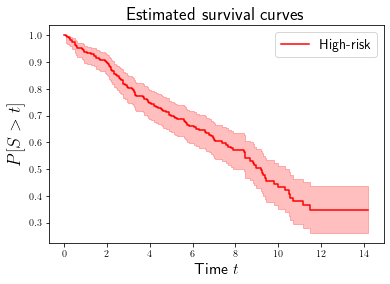

In [30]:
fontsize = 16
# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
kmf.fit(T_train, delta_train, label="High-risk").plot(c='r')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Estimated survival curves", size=fontsize+2)
plt.show()

### Visualize longitudinal processes for a randomly chosen

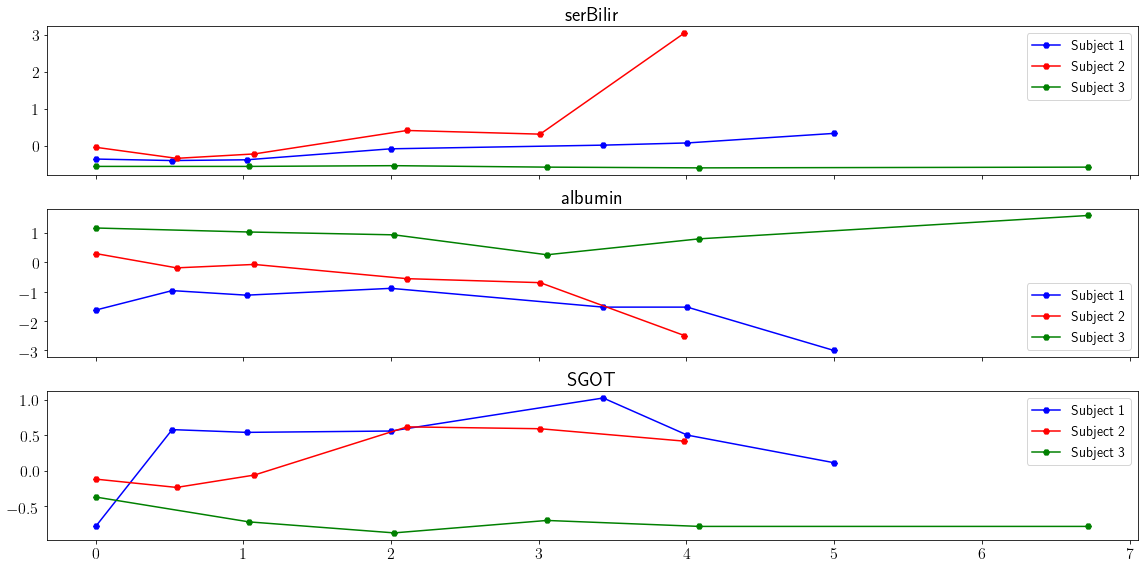

In [31]:
np.random.seed(10)
fig = plt.figure(figsize=(16, 8))
ax0 = plt.subplot(n_long_features,1,1)
colors, labels = ['b', 'r', 'g'], ['Subject 1', 'Subject 2', 'Subject 3']
idx_list = [2, 3, 4]
for k in [0, 1, 2]:
    #idx = np.random.choice(Y.index)
    idx = idx_list[k]
    Y_i = Y_train.loc[idx, :]
    label, color = labels[k], colors[k]
    for l in range(n_long_features):
        Y_il = Y_i[long_features_list[l]]
        ax = plt.subplot(n_long_features,1 ,l+1 , sharex=ax0)
        Y_il.plot(label=label, color=color, marker='H')
        ax.set_title(long_features_list[l], fontsize=fontsize+4)
        plt.xticks(fontsize=fontsize), plt.yticks(fontsize=fontsize)
        plt.legend(fontsize=fontsize-2)
fig.tight_layout()
plt.show()

Launching the solver prox_QNMCEM...
Launching the solver MLMM...
Launching the solver ULMM...
Done solving using ULMM in 1.55e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  5408.25 |      inf
       1 |  5100.14 | 5.70e-02
       2 |  5052.17 | 9.40e-03
       3 |  5030.07 | 4.37e-03
       4 |  5017.73 | 2.45e-03
       5 |  5010.13 | 1.52e-03
       6 |   5005.1 | 1.00e-03
       7 |  5001.59 | 7.01e-04
       8 |  4999.04 | 5.11e-04
       9 |  4997.11 | 3.85e-04
      10 |  4995.63 | 2.97e-04
Done solving using MLMM in 2.73e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  49.5874 |      inf
       1 |  27.5761 | 4.44e-01
       2 |   26.646 | 3.37e-02
       3 |  25.8381 | 3.03e-02
       4 |  25.2184 | 2.40e-02
       5 |  24.9406 | 1.10e-02
       6 |  24.8138 | 5.08e-03
       7 |  24.8079 | 2.39e-04
       8 |  24.7098 | 3.95e-03
       9 |  24.5669 | 5.78e-03
      10 |  24.4846 | 3.35e-03
Done solving using prox_QNMCEM in 1.48e+02 seconds


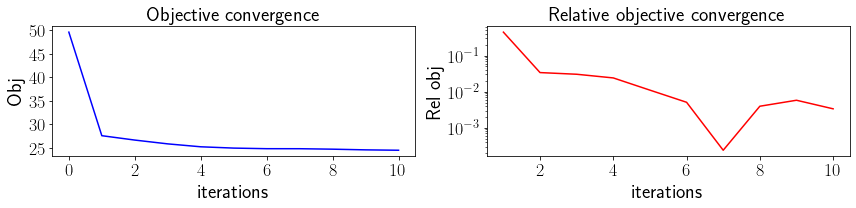

In [32]:
## Choose parameters ##
tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.3             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
gamma_chosen = '1se'  # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'

# declare learner here
fixed_effect_time_order = 1
learner = prox_QNMCEM(fixed_effect_time_order=fixed_effect_time_order,
                max_iter=10, initialize=True, print_every=1,
               compute_obj=True, simu=False, asso_functions=["lp", "re"],
                      l_pen_SGL=0.02, eta_sp_gp_l1=.9, l_pen_EN=0.02)
learner.fit(X_train, Y_train, T_train, delta_train)

# Visualize learning
visualize_vect_learning(learner, "obj")

In [33]:
def visualize_vect_learning_pbc(learner, name, symbol = None,
                            legend_est = None, legend_true = None):
    """Plots learning for a given parameter vector : objective and relative
    objective function, as well as evolution of estimators through iterations

    Parameters
    ----------
    learner : `ligths.base.base.Learner`
        A base learner

    name : `str`
        Name of the element to be plotted

    symbol : `str`
        Symbol of the element to be plotted

    legend_est : `list`
        Names of each estimator coefficients

    legend_true : `list`
        Names of each true parameter coefficients
    """
    fs = 18
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    plt.title("%s learning" % symbol, fontsize=fs + 2)
    plt.xlabel('iterations', fontsize=fs + 2)
    plt.xticks(fontsize=fs), plt.yticks(fontsize=fs)
    cm = 'Dark2'
    plot_history(learner, name=name, ax=ax, colormap=cm, alpha=.8)

    legend1 = ax.legend(legend_est, loc='center right',
                        bbox_to_anchor=(-0.1, 0.5), fontsize=fs)
    plt.gca().add_artist(legend1)

    fig.tight_layout()
    plt.show()

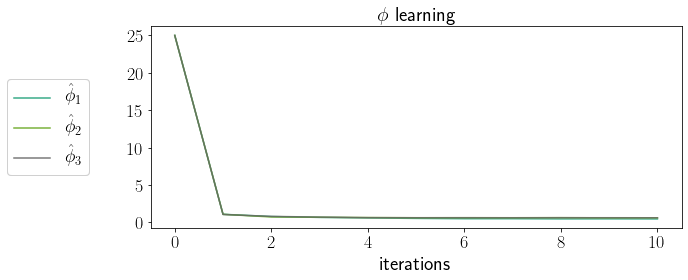

In [34]:
# Visualize phi
to = len(learner.theta["phi"])+1
leg1 = [r"$\hat \phi_%s$" % j for j in range(1, to)]
leg2 = [r"$\phi_%s$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "phi", symbol = r"$\phi$", legend_est = leg1, legend_true = leg2)

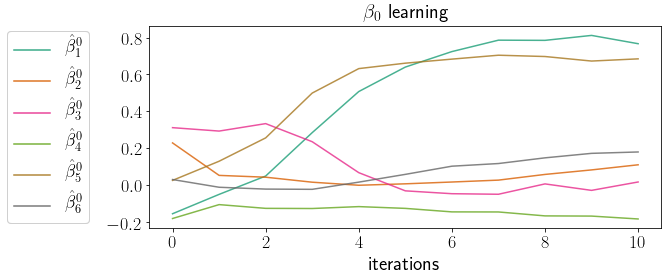

In [35]:
# Visualize beta_0
to = len(learner.theta["beta_0"])+1
leg1 = [r"$\hat \beta^0_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^0_%s$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "beta_0", r"$\beta_0$", leg1, leg2)

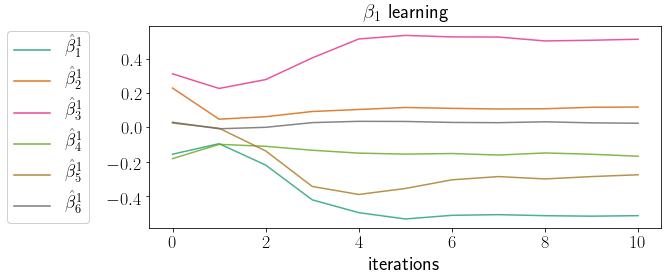

In [36]:
# Visualize beta_1
to = len(learner.theta["beta_1"])+1
leg1 = [r"$\hat \beta^1_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^1_%s$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "beta_1", r"$\beta_1$", leg1, leg2)

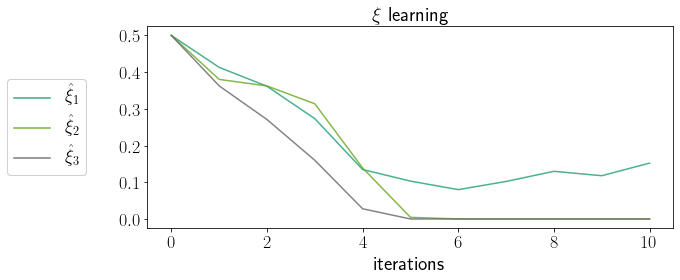

In [37]:
# Visualize xi
to = len(learner.theta["xi"])+1
leg1 = [r"$\hat \xi_%s$" % j for j in range(1, to)]
leg2 = [r"$\xi_%s$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "xi", r"$\xi$", leg1, leg2)

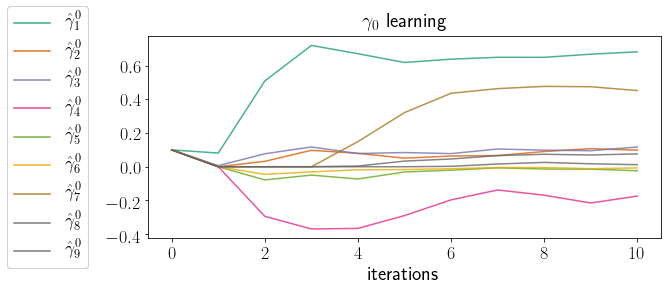

In [38]:
# Visualize gamma_0
to = len(learner.theta["gamma_0"])+1
leg1 = [r"$\hat \gamma^0_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^0_{%s}$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "gamma_0", r"$\gamma_0$", leg1, leg2)

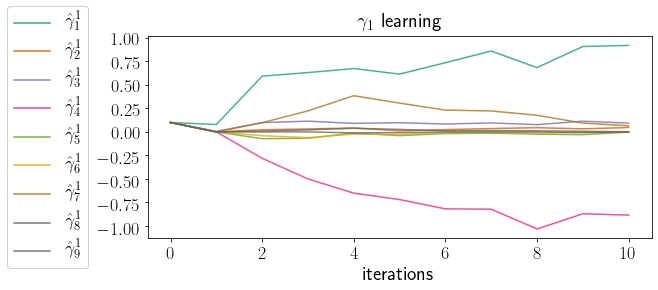

In [39]:
# Visualize gamma_0
to = len(learner.theta["gamma_1"])+1
leg1 = [r"$\hat \gamma^1_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^1_{%s}$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "gamma_1", r"$\gamma_1$", leg1, leg2)

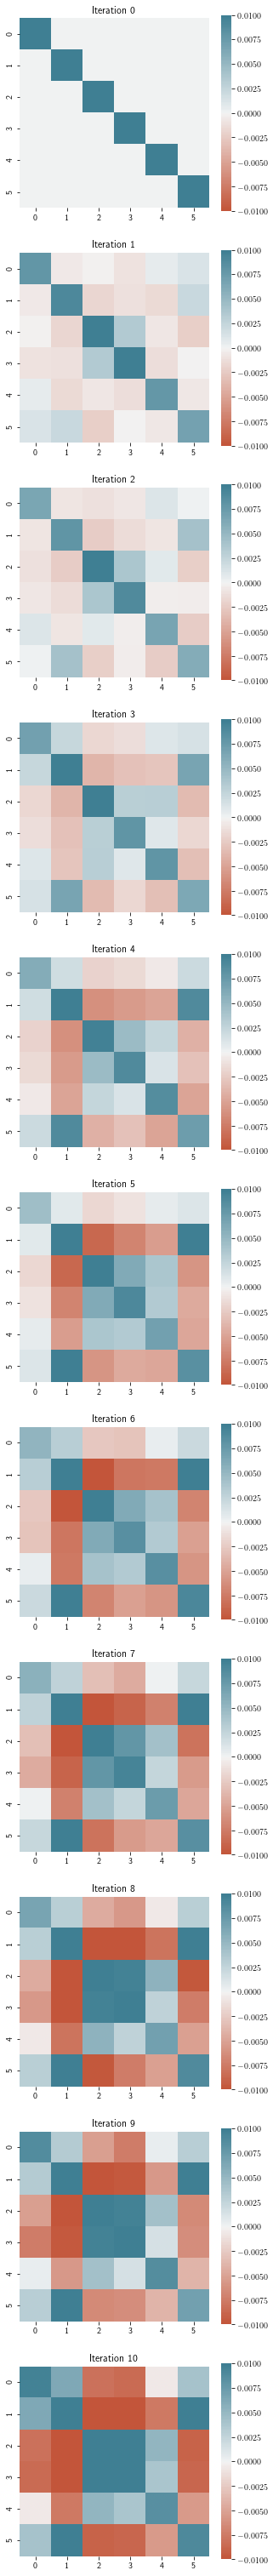

In [44]:
long_cov_history = learner.history.values["long_cov"]
fig, axes = plt.subplots(len(long_cov_history), 1, figsize=(5, 5 * len(long_cov_history)), sharey=True)
for i in range(len(long_cov_history)):
    sns.heatmap(
    data=long_cov_history[i], 
    vmin=-.01, vmax=.01, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax=axes[i]
    )
    axes[i].set_title("Iteration {}".format(i))

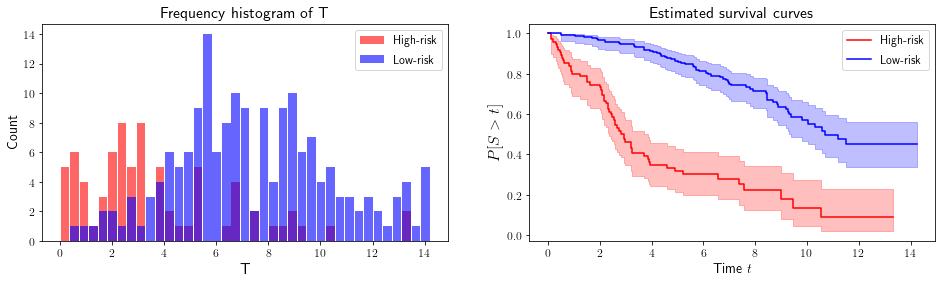

In [40]:
fig = plt.figure(figsize=(16, 4))
fontsize = 14
ax = fig.add_subplot(1,2,1)
bins = np.linspace(0, T_train.max(), 40)
kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
plt.hist(T_train[learner.pi_est < .5], **kwargs, color='r', label='High-risk')
plt.hist(T_train[learner.pi_est > .5], **kwargs, color='b', label='Low-risk')
plt.legend(fontsize=fontsize-2)
plt.xlabel("T", size=fontsize+2)
plt.ylabel("Count", size=fontsize)
ax.tick_params(labelsize=fontsize-2)
plt.title("Frequency histogram of T", size=fontsize+2)

# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
ax = plt.subplot(122)
kmf.fit(T_train[learner.pi_est < .5], delta_train[learner.pi_est < .5], label="High-risk").plot(ax=ax, c='r')
kmf.fit(T_train[learner.pi_est > .5], delta_train[learner.pi_est > .5], label="Low-risk").plot(ax=ax, c='b')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Estimated survival curves", size=fontsize+2)
ax.tick_params(labelsize=fontsize-2)
plt.show()

In [41]:
# evalutation here
marker_train = learner.predict_marker(X_train, Y_train)
c_index_train = c_index_score(T_train, marker_train, delta_train)
c_index_train = max(c_index_train, 1 - c_index_train)


# prediction here
marker_test = learner.predict_marker(X_test, Y_test)
c_index_test = c_index_score(T_test, marker_test, delta_test)
c_index_test = max(c_index_test, 1 - c_index_test)

print("Done predicting on dataset.")
print("C-index on train: %.2f" % c_index_train)
print("C-index on test: %.2f" % c_index_test)

Done predicting on dataset.
C-index on train: 0.78
C-index on test: 0.82
